In [1]:
import numpy as np
import cv2, warnings, matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', '.*do not*')
%matplotlib inline

In [2]:
img = cv2.imread('./test_images/messi1.jpg')

In [3]:
img.shape

(324, 324, 3)

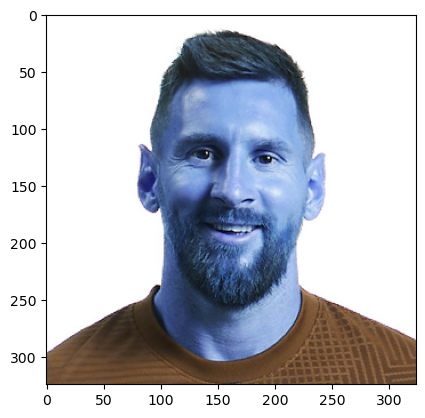

In [4]:
plt.imshow(img)    

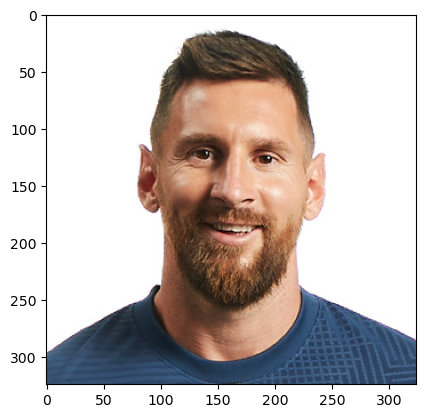

In [5]:
#convert bgr into rgb using cv2
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

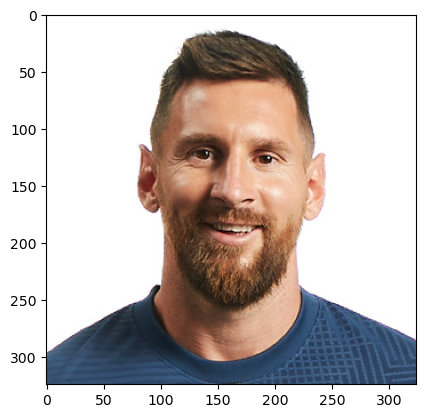

In [6]:
#bgr converted to rgb
plt.imshow(img[:,:,::-1])

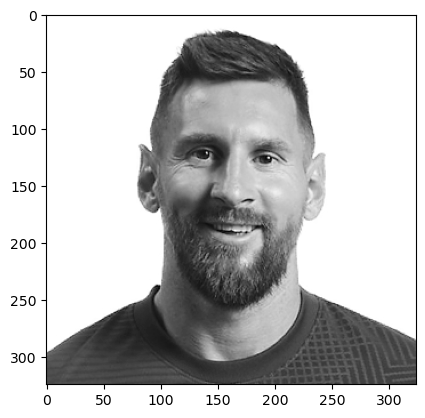

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [8]:
gray.shape  #two dimensional

(324, 324)

In [9]:
#detect x,y,w,h 
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 83,  60, 164, 164]], dtype=int32)

In [10]:
(x,y,w,h) = faces[0]
f'{x= }, {y= }, {w= }, {h= }'

'x= 83, y= 60, w= 164, h= 164'

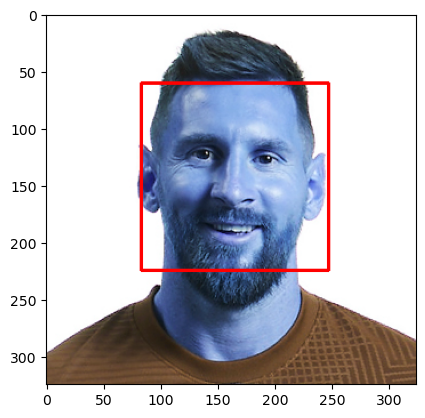

In [11]:
face_img = cv2.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

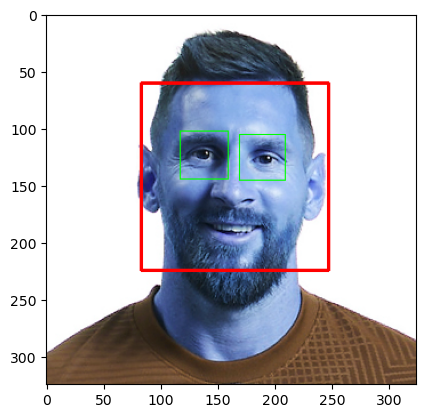

In [12]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 1)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,255,0), 1)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

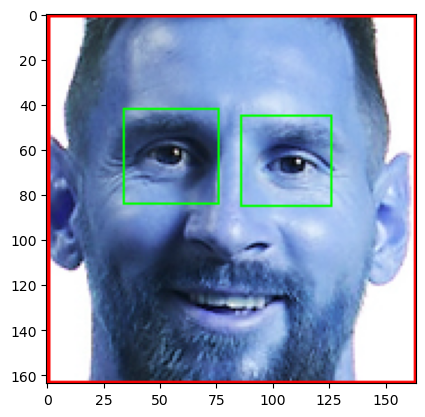

In [13]:
plt.imshow(roi_color, cmap='gray')

In [14]:
cropped_img = np.array(roi_color)
cropped_img.shape

(164, 164, 3)

In [15]:
#wavelet transform
import pywt, cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale, step-1
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float, step-2
    imArray =  np.float32(imArray) 
    imArray /= 255;
    # compute coefficients 
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H = list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    return imArray_H

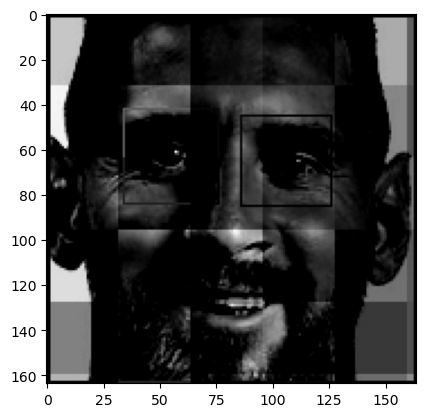

In [16]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [17]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

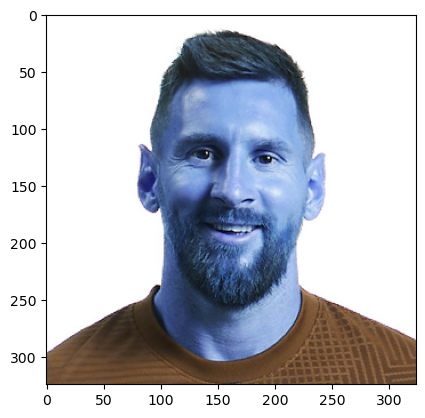

In [18]:
original_image = cv2.imread('./test_images/messi1.jpg')
plt.imshow(original_image)

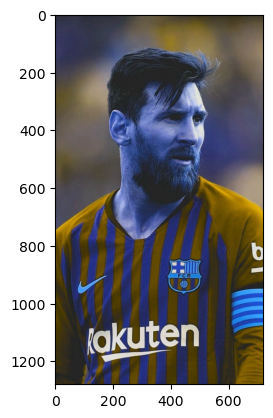

In [19]:
#unuseful image
orig_image_obstructed = cv2.imread('./test_images/messi2.jpg')
plt.imshow(orig_image_obstructed)

In [20]:
path_to_data = './dataset/'
path_to_cr_data = ''.join([path_to_data, 'cropped'])

In [21]:
import os
img_dirs = []

for entry in os.scandir(path_to_data):
    if not entry.name.startswith('.') and entry.name != 'cropped':
        img_dirs.append(entry.path)
img_dirs

['./dataset/maria_sharapova',
 './dataset/virat_kohli',
 './dataset/lionel_messi',
 './dataset/serena_williams',
 './dataset/roger_federer']

In [22]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [23]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
class_dict = {}
file_list = []

i = 0
for img_dir in img_dirs:
    j = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    class_dict[celebrity_name] = i
    i += 1
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        
        if roi_color is not None:
            cropped_folder = '/'.join([path_to_cr_data, celebrity_name])
        
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print(f'Generating cropped images in folder: {cropped_folder}')
            
            
            cropped_file_name = ''.join([celebrity_name, f'{j}', '.png'])
            cropped_file_path = '/'.join([cropped_folder, cropped_file_name])
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            j += 1
            
class_dict

Generating cropped images in folder: ./dataset/cropped/maria_sharapova
Generating cropped images in folder: ./dataset/cropped/virat_kohli
Generating cropped images in folder: ./dataset/cropped/lionel_messi
Generating cropped images in folder: ./dataset/cropped/serena_williams
Generating cropped images in folder: ./dataset/cropped/roger_federer


{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

In [24]:
#stackoverflow
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack([scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)])
        X.append(combined_img)
        y.append(class_dict[celebrity_name])
        

In [25]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape
#data cleaning process is done

(309, 4096)

In [26]:
#initiative svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
np.round(pipe.score(X_test, y_test), 2)

0.87

In [28]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.89      0.89      0.89        18
           2       0.89      0.89      0.89        19
           3       0.77      1.00      0.87        20
           4       1.00      0.80      0.89        10

    accuracy                           0.87        78
   macro avg       0.91      0.84      0.86        78
weighted avg       0.89      0.87      0.87        78



In [29]:
#GridSearch
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [30]:
model_params = {
#1
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']            
        }
    },
#2  
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
#3  
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [31]:
scores = []
best_estimators = {}
import pandas as pd

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.891674,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.801110,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.870213,{'logisticregression__C': 1}


In [32]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [33]:
best_estimators['svm'].score(X_test, y_test)

0.8717948717948718

In [34]:
best_estimators['random_forest'].score(X_test, y_test)

0.8076923076923077

In [35]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8846153846153846

In [36]:
best_clf = best_estimators['logistic_regression']
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  1,  2,  0],
       [ 0, 16,  0,  2,  0],
       [ 0,  0, 19,  0,  0],
       [ 0,  0,  2, 18,  0],
       [ 0,  0,  2,  0,  8]])

In [38]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [39]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))
'Code Finished...'

'Code Finished...'